# Embedding new single-cell samples into an existing embedding

In this notebook, we demonstrate the procedure from _Embedding to Reference t-SNE Space Addresses Batch Effects in Single-Cell Classification_ using our t-SNE implementation _openTSNE_.

We will take the pancreatic cell atlas from _Baron et al._ and build a reference embedding on that. Then, we choose data from _Xin et al._, another single-cell data set containing pancreatic cells, and embed these into the same t-SNE space.

In [1]:
from os import path

import sys
sys.path.append(path.join("..", "notebooks"))
sys.path.append(path.join("..", "notebooks", "utils.py"))
import utils

from openTSNE import TSNE, TSNEEmbedding
from openTSNE import affinity
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

import numpy as np
import pandas as pd
import scipy.sparse as sp
import scanpy as sc
import anndata

import matplotlib.pyplot as plt
%matplotlib inline

/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Prepare reference embedding

Although we can use t-SNE to embed new samples into any previous embedding (i.e. instead of using t-SNE for our initial embedding, we could also use PCA, MDS, UMAP, ...), it's convenient to use t-SNE.

### Prepare reference data set

We load the data set and perform some basic QC. Afterwards, we select 3,000 informative genes. Then, we perform library size normalization, log transformation and standardization. Finally, we use PCA to extract the top 50 principal components. This is then used to construct the t-SNE embedding.

In [2]:
adata = anndata.read_h5ad(path.join("..", "data", "baron_2016h.h5ad"))
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 8569 × 17499 
    obs: 'batch_id', 'labels'
    var: 'n_counts'
    uns: 'name', 'organism', 'tissue', 'year'

Chosen offset: 0.18


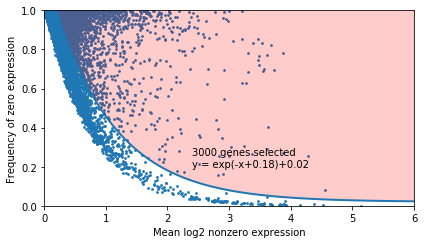

In [3]:
gene_mask = utils.select_genes(adata.X, n=3000, threshold=0)

In [4]:
adata_norm = adata.copy()
sc.pp.normalize_per_cell(adata_norm, counts_per_cell_after=1_000_000)
sc.pp.log1p(adata_norm)

In [5]:
adata_norm.X = adata_norm.X.toarray()
adata_norm.X -= adata_norm.X.mean(axis=0)
adata_norm.X /= adata_norm.X.std(axis=0)

In [6]:
adata_3000 = adata_norm[:, gene_mask].copy()

In [7]:
%%time
U, S, V = np.linalg.svd(adata_3000.X, full_matrices=False)
U[:, np.sum(V, axis=1) < 0] *= -1
adata_3000.obsm["pca"] = np.dot(U, np.diag(S))
adata_3000.obsm["pca"] = adata_3000.obsm["pca"][:, np.argsort(S)[::-1]][:, :50]

CPU times: user 2min 23s, sys: 7.99 s, total: 2min 31s
Wall time: 4.32 s


### Construct t-SNE embedding

We use multi-scale t-SNE with PCA initialization so as to preserve the hierarchical relationships between the clusters.

In [8]:
%%time
affinities = affinity.Multiscale(
    adata_3000.obsm["pca"],
    perplexities=[50, 500],
    metric="cosine",
    n_jobs=8,
    random_state=3,
)
init = initialization.pca(adata_3000.obsm["pca"], random_state=42)
embedding = TSNEEmbedding(
    init,
    affinities,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=[ErrorLogger()],
)
embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
embedding.optimize(n_iter=750, exaggeration=1, momentum=0.8, inplace=True)

adata_3000.obsm["tsne"] = embedding

Iteration   50, KL divergence  2.4342, 50 iterations in 1.6579 sec
Iteration  100, KL divergence  2.2323, 50 iterations in 1.5812 sec
Iteration  150, KL divergence  2.1799, 50 iterations in 1.5950 sec
Iteration  200, KL divergence  2.1550, 50 iterations in 1.5956 sec
Iteration  250, KL divergence  2.1401, 50 iterations in 1.6009 sec
Iteration   50, KL divergence  1.0720, 50 iterations in 1.5858 sec
Iteration  100, KL divergence  0.8524, 50 iterations in 1.5785 sec
Iteration  150, KL divergence  0.7671, 50 iterations in 1.6134 sec
Iteration  200, KL divergence  0.7241, 50 iterations in 1.5741 sec
Iteration  250, KL divergence  0.7009, 50 iterations in 1.7882 sec
Iteration  300, KL divergence  0.6883, 50 iterations in 1.7278 sec
Iteration  350, KL divergence  0.6809, 50 iterations in 2.5293 sec
Iteration  400, KL divergence  0.6742, 50 iterations in 2.5902 sec
Iteration  450, KL divergence  0.6698, 50 iterations in 1.9429 sec
Iteration  500, KL divergence  0.6658, 50 iterations in 1.7763

In [9]:
colors = utils.get_colors_for(adata)

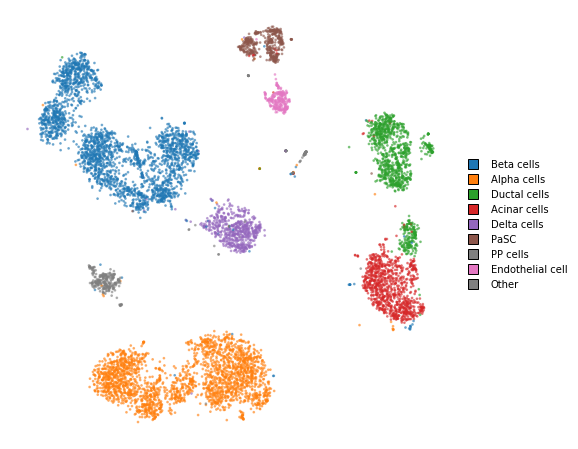

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis("equal")

utils.plot(adata_3000.obsm["tsne"], adata_3000.obs["labels"], s=3, colors=colors, draw_legend=True, ax=ax, alpha=0.5, label_order=list(colors.keys()))

## Adding samples into the reference embedding

Now that we have a visualization for the reference data set, we can begin to add new samples into the shared embedding space. 

In [11]:
new = anndata.read_h5ad(path.join("..", "data", "xin_2016.h5ad"))

To estimate similarities between the samples in the secondary data set and the reference data set, it makes sense to only consider shared genes.

In [12]:
shared_genes = adata.var_names[adata.var_names.isin(new.var_names)]
shared_genes

Index(['A1BG', 'A1CF', 'A2M', 'A4GALT', 'AAAS', 'AACS', 'AACSP1', 'AADAC',
       'AADACL2', 'AADAT',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='index', length=17078)

In [13]:
adata = adata[:, adata.var_names.isin(shared_genes)]
new = new[:, new.var_names.isin(shared_genes)]

In [14]:
adata = adata[:, adata.var_names.argsort()].copy()
new = new[:, new.var_names.argsort()].copy()
assert all(adata.var_names == new.var_names)

Next, we use the same gene selection procedure to select the 1,000 most informative genes using the _reference data set_ only.

Chosen offset: 0.45


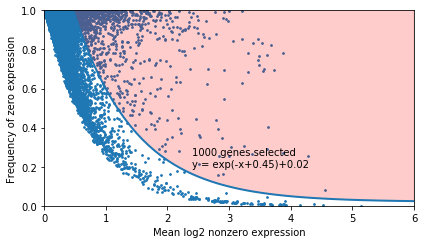

In [15]:
gene_mask = utils.select_genes(adata.X, n=1000, threshold=0)

In [16]:
adata_1000 = adata[:, gene_mask].copy()
new_1000 = new[:, gene_mask].copy()

### Estimating similarities between data sets

We can now use the reduced data sets and estimate distances between data points. We do this on raw counts using cosine similarity.

In [17]:
%%time
affinities = affinity.PerplexityBasedNN(
    adata_1000.X.toarray() if sp.issparse(adata_1000.X) else adata_1000.X,
    perplexity=30,
    metric="cosine",
    n_jobs=8,
    random_state=3,
)

CPU times: user 3min 19s, sys: 1.23 s, total: 3min 20s
Wall time: 42.6 s


Next, we need to create the openTSNE emedding object, with which we'll get initial positions for the secondary data set.

In [18]:
embedding = TSNEEmbedding(
    adata_3000.obsm["tsne"],
    affinities,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=[ErrorLogger()],
)

We position each new data point to the median position of its 10 nearest neighbors in the reference embedding.

In [19]:
%time new_embedding = embedding.prepare_partial(new_1000.X.toarray(), initialization="median", k=10)

CPU times: user 27.7 s, sys: 1.05 s, total: 28.7 s
Wall time: 4.01 s


Now that we've estimated the similarities between data points and have a reasonable initialization, the only thing remaining is to run optmization for any number of steps.

In [20]:
%%time
new_embedding.optimize(250, learning_rate=0.1, momentum=0.8, inplace=True)

new_1000.obsm["tsne"] = new_embedding

Iteration   50, KL divergence  16688.1268, 50 iterations in 3.9421 sec
Iteration  100, KL divergence  16676.7606, 50 iterations in 3.9066 sec
Iteration  150, KL divergence  16676.4969, 50 iterations in 3.8685 sec
Iteration  200, KL divergence  16677.1161, 50 iterations in 1.7219 sec
Iteration  250, KL divergence  16676.1232, 50 iterations in 2.9995 sec
CPU times: user 2min 8s, sys: 2.17 s, total: 2min 10s
Wall time: 16.5 s


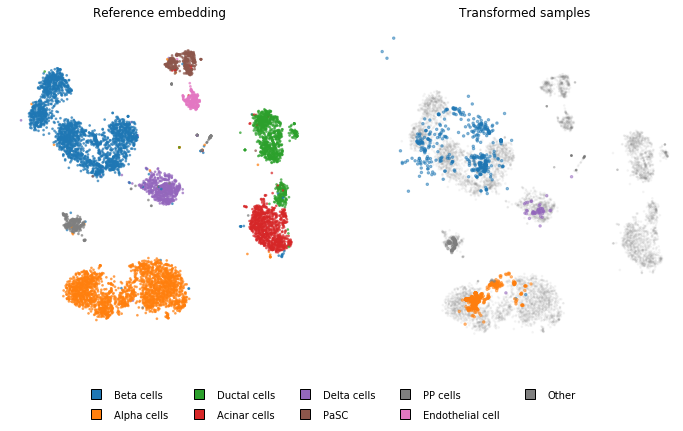

In [21]:
cell_order = list(colors.keys())
num_cell_types = len(np.unique(adata.obs["labels"]))

fig, ax = plt.subplots(ncols=2, figsize=(12, 6))

utils.plot(adata_3000.obsm["tsne"], adata_3000.obs["labels"], ax=ax[0], title="Reference embedding", colors=colors, s=3, label_order=cell_order,
          legend_kwargs=dict(loc="upper center", bbox_to_anchor=(0.5, 0.05), bbox_transform=fig.transFigure, labelspacing=1, ncol=num_cell_types // 2 + 1))

colors_bw = {1: "#666666"}
utils.plot(adata_3000.obsm["tsne"], np.ones_like(adata_3000.obs["labels"]), ax=ax[1], colors=colors_bw, alpha=0.05, s=3, draw_legend=False)
utils.plot(new_1000.obsm["tsne"], new_1000.obs["labels"], ax=ax[1], colors=colors, draw_legend=False, s=6, label_order=cell_order, alpha=0.5)
ax[1].set_title("Transformed samples")

for ax_ in ax.ravel(): ax_.axis("equal")